In [1]:
import pandas as pd
import cv2
import torch
import random
import gc
import time
import numpy as np
import sys
import torch.nn as nn
import torch.nn.functional as F
import os
from datetime import datetime
import torchvision
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from transformers import ViTFeatureExtractor, ViTModel
from transformers import AdamW, get_linear_schedule_with_warmup
import math

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
EPOCHS = 25
lr = 2e-5
SEED = 42
BATCH_SIZE = 24
accumulation_steps = 4
seed_everything(SEED)

In [3]:
df = pd.read_csv('../input/caltech256/caltech256.csv')
df.head(2)

,Unnamed: 0,fold,label,path
0,0,1,0,001.ak47/001_0001.jpg
1,1,1,0,001.ak47/001_0002.jpg


In [4]:
valid = df[df['fold']==1].reset_index(drop=True)
train = df[df['fold']!=1].reset_index(drop=True)
print(valid.shape,train.shape)

(6222, 4) (24385, 4)


In [5]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

class CassavaDataset(Dataset):
    def __init__(self, df,transforms=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = '../input/caltech256/256_ObjectCategories/256_ObjectCategories'
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['path'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

In [6]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Normalize,Resize, Compose
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            Resize(224,224),
            HorizontalFlip(p=0.3),
            VerticalFlip(p=0.3),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            Resize(224,224),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [7]:
valid_ds = CassavaDataset(valid, transforms=get_valid_transforms(), output_label=True)
train_ds = CassavaDataset(train, transforms=get_train_transforms(), output_label=True)

In [8]:
train_loader = torch.utils.data.DataLoader(
            train_ds, 
            batch_size=32,
            num_workers=4,
            shuffle=True,
            pin_memory=False,
        )
        
valid_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=32,
            num_workers=4,
            shuffle=False,
            pin_memory=False,
        )

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=4).permute(1, 2, 0))
def show_batch(dl, nmax=8):
    for images,labels in dl:
        show_images(images,8)
        break

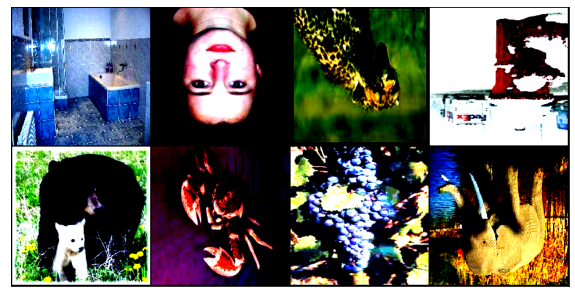

In [10]:
show_batch(train_loader)

In [11]:
class ArcModule(nn.Module):
    def __init__(self, in_features=768, out_features=151, s = 10, m =0.5):
        super().__init__()
        self.in_features = 768
        self.out_features = 151
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        cos_th = cos_th.clamp(-1, 1)
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        onehot.scatter_(1, labels, 1.0)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs

In [12]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [13]:
class VitModel(nn.Module):
    def __init__(self,latent_dim=512,n_classes=257):
        super(VitModel, self).__init__()
        
        self.classes_ = n_classes
        
        self.vit =  ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc_out = nn.Linear(768, latent_dim)
        self.dropout = nn.Dropout(0.2)
        self.margin =  ArcMarginProduct(in_features=512, out_features = self.classes_)
        
    def forward(self, in_data,label):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)
        
        pooler_output = vit_outputs.pooler_output
        proj= self.fc_out(self.dropout(pooler_output))
        out = self.margin(proj,label)
        return {'proj':proj,'label':out}

In [14]:
def valid_func(model,valid_loader):
    model.eval()
    bar = tqdm(valid_loader,file=sys.stdout)
    loss_fn = torch.nn.CrossEntropyLoss()
    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images,labels) in enumerate(bar):
            images = images.cuda()
            targets = labels.long().view(-1).cuda()

            logits = model(images,targets)

            PREDS += [torch.argmax(logits['label'], 1).detach().cpu()]
            TARGETS += [targets.detach().cpu()]

            loss = loss_fn (logits['label'], targets)
            losses.append(loss.item())
           
            bar.set_description(f'loss: {loss.item():.5f}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS==TARGETS).mean()
   
    loss_valid = np.mean(losses)
    return loss_valid, accuracy

In [15]:
use_amp = False
debug = False
gc.collect()
best_epoch_loss = np.inf
# debug = True
# train_loader = torch.utils.data.DataLoader(ClinicDataset(train), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# val_loader = torch.utils.data.DataLoader(ClinicDataset(valid), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

net = VitModel()
net.cuda()
log_df = pd.DataFrame(columns = ['Epoch','Train_Loss','Valid_Loss','Valid_Accuracy'])

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = AdamW(net.parameters(), lr = lr)    
# param_optimizer = list(net.named_parameters())
# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [
# {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
# {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
# ]
num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.05 * num_train_optimization_steps,
                                    num_training_steps=num_train_optimization_steps)# PyTorch scheduler
if use_amp:
        scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    start_time = time.time()
    avg_loss = 0.0
    net.train()
    tbar = tqdm(train_loader, file=sys.stdout)
    loss_list = []
    val_loss_list = []
    for step, (images,labels) in enumerate(tbar):
        if debug and step == 10:
            print('Debug Mode. Only train on first 100 batches.')
            break
        input_ids = images.cuda()
        targets = labels.long().view(-1).cuda()
        if use_amp:
                with torch.cuda.amp.autocast():
                     pred = net(input_ids,targets)
                     loss = loss_fn(pred['label'], targets)
                scaler.scale(loss).backward()
                if step % accumulation_steps == 0 or step == len(tbar) - 1:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()
        else:
            pred = net(input_ids,targets)
            loss = loss_fn(pred['label'], targets)
            loss = loss / accumulation_steps
            loss.backward()
            if step % accumulation_steps == 0 or step == len(tbar) - 1:
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
       

    loss_list.append(loss.detach().cpu().item())
    avg_loss = np.round(np.mean(loss_list), 4)
    tbar.set_description(f"Epoch {epoch + 1} Loss: {avg_loss} lr: {scheduler.get_last_lr()}")
    vloss,vaccuracy = valid_func(net,valid_loader )
    log_df.loc[len(log_df.index)] = [epoch+1,avg_loss,vloss,vaccuracy]
    print(f'Epoch--{epoch+1} ### Train loss---{avg_loss} ### Valid_Loss---{vloss} ### Valid_Acc---{vaccuracy}')
    if vloss<best_epoch_loss:
        best_epoch_loss = vloss
        PATH = f"Vit-Base_224_epoch__{epoch}.pth"
        torch.save(net.state_dict(), PATH)
        print(f'Model Saved--epoch--{epoch+1}')
        
    
del train_loader
del net
del valid_loader
gc.collect()

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementat

loss: 16.63849: 100%|██████████| 195/195 [00:48<00:00,  4.04it/s]
Epoch--1 ### Train loss---4.5107 ### Valid_Loss---17.259189750598026 ### Valid_Acc---0.03567984570877531
Model Saved--epoch--1
loss: 6.79423: 100%|██████████| 195/195 [00:43<00:00,  4.45it/s]
Epoch--2 ### Train loss---4.3136 ### Valid_Loss---10.695361142758376 ### Valid_Acc---0.1168434586949534
Model Saved--epoch--2
loss: 7.23928: 100%|██████████| 195/195 [00:45<00:00,  4.32it/s]
Epoch--3 ### Train loss---3.0058 ### Valid_Loss---6.132210495810096 ### Valid_Acc---0.36483445837351336
Model Saved--epoch--3
loss: 7.14259: 100%|██████████| 195/195 [00:44<00:00,  4.37it/s]
Epoch--4 ### Train loss---0.6129 ### Valid_Loss---3.7983978175152187 ### Valid_Acc---0.6337190613950499
Model Saved--epoch--4
loss: 8.64616: 100%|██████████| 195/195 [00:44<00:00,  4.43it/s]
Epoch--5 ### Train loss---0.8991 ### Valid_Loss---2.8864543090072963 ### Valid_Acc---0.7467052394728383
Model Saved--epoch--5
loss: 8.86539: 100%|██████████| 195/195 [00

30